In [3]:
from food.tools import *
from food.paths import *
from food.psql import *
import numpy as np
import torch
from torch.nn import CosineSimilarity
import requests
from food.qdrant import *
cos = CosineSimilarity(dim=1, eps=1e-08)
import pandas as pd

In [4]:
def search_image(url=None,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    image_clip = torch.Tensor(image_clip)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return image_clip,df.reset_index()

series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [66]:
collection_name = 'food'
table = 'foods'
foods = read_sql(table)
foods = foods.set_index('id')

In [67]:
text_to_vector = lambda text: torch.Tensor(requests.post(f'https://guru.skynet.center/text2vector/?text={text}').json())

In [68]:
types = ['food','foods']
types_ = [text_to_vector(f'{t}') for t in types ]

types_ = torch.cat(types_).reshape(len(types),768)

In [69]:
drop_vector =      lambda clip, i: torch.cat([clip[0:i], clip[i+1:]])

def multiply_vector(clip,i,n=1):
    duplicated = torch.cat([clip[i].reshape(1,768) for _ in range(n)])
    return torch.cat([clip, duplicated.reshape(n,768)])

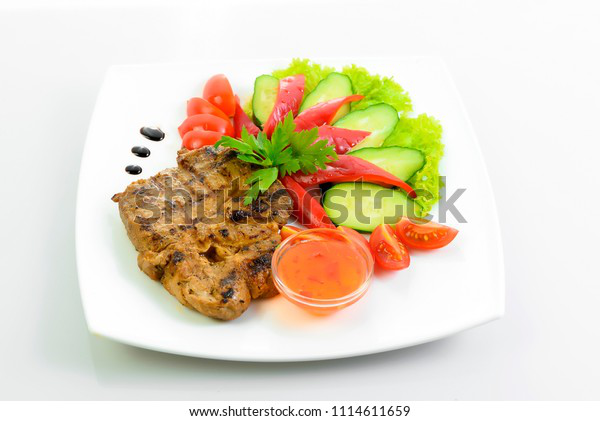

In [99]:
read_image_from_url(url)

In [100]:
values = cos(image_clip.reshape(1,768), types_.reshape(len(types),768))

In [101]:
pd.DataFrame({'types':types,'values':values}).sort_values('values',ascending = False)

,types,values
1,foods,0.230112
0,food,0.221621


In [570]:
url = 'https://image.shutterstock.com/image-photo/arayes-pita-bread-filled-mixture-600w-1584655636.jpg'
image_clip,df = search_image(url,head=100)

In [571]:
selected = df.copy()

In [572]:
selected['altered_description'] = ('the food is ' +
                                  selected['category'] + ' .'
                                  ' It has a little bit of  ' +
                                  selected['description'].str.split(',').apply(lambda l:' '.join(list(reversed(l))))
                                #   ' which blongs to ' 
                                  # + selected['category']
                                  ).str.lower().str.replace(':','')
                                   #selected['category']#+' '+selected['description'].str.replace(',','') I am going to eat some )

In [573]:
clip = []
for i in selected.index:
    text = selected.loc[i,'altered_description']
    clip.append(requests.post(f'https://guru.skynet.center/text2vector/?text={text}').json())
selected['clip'] = clip

In [574]:
selected = selected.reset_index(drop=True)
clip = series2tensor(selected['clip'])
initscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))

startscore = initscore.detach().clone()-0.00001

while startscore !=initscore:
    startscore = initscore.detach().clone()
    
    selected = selected.reset_index(drop=True)
    for i in reversed(selected.index):
        clip = series2tensor(selected['clip'])
        dropped = drop_vector(clip,i)
        testscore = cos(image_clip.reshape(1,768), dropped.mean(0).reshape(1,768))

        if testscore > initscore-0.0001: 
            r = selected.loc[i,'altered_description']
            selected = selected.drop(i)
            initscore = testscore

        else:
            extra = multiply_vector(clip,i,1)
            testscore = cos(image_clip.reshape(1,768), extra.mean(0).reshape(1,768))
            if testscore > initscore: 
                selected = selected.append(selected.loc[i])
                initscore = testscore


        

    print(initscore)
    count = selected.groupby('altered_description')['clip'].count().sort_index()
    r = selected.drop_duplicates('altered_description').set_index("altered_description").sort_index()
    r['count'] = count
    r = r.sort_values('count',ascending = False)
    r['cumcount'] = r['count'].cumsum()/r['count'].sum()
    r.drop(columns = ['clip'])

tensor([0.3012], dtype=torch.float64)
tensor([0.3170], dtype=torch.float64)
tensor([0.3180], dtype=torch.float64)
tensor([0.3180], dtype=torch.float64)


In [575]:
initscore,startscore

(tensor([0.3180], dtype=torch.float64), tensor([0.3180], dtype=torch.float64))

In [576]:
r

,id,description,category,energy,protein,carb,fat,clip,score,count,cumcount
altered_description,,,,,,,,,,,
the food is other sandwiches (single code) . it has a little bit of with tomato and spread condiments) onion lamb beef gyro sandwich (pita bread,1099837,"Gyro sandwich (pita bread, beef, lamb, onion, ...",Other sandwiches (single code),167.0,11.92,18.52,4.77,"[0.04660886526107788, -0.01619405671954155, 0....",0.285497,7,0.466667
the food is other mexican mixed dishes . it has a little bit of quesadilla with vegetables and meat,1101953,Quesadilla with vegetables and meat,Other Mexican mixed dishes,318.0,12.94,29.18,16.39,"[0.03987971693277359, -0.03283333405852318, 0....",0.314710,3,0.666667
"the food is beef, excludes ground . it has a little bit of thinly sliced formed flaked sandwich steak beef",1098211,"Beef, sandwich steak, flaked, formed, thinly s...","Beef, excludes ground",329.0,18.41,0.00,27.81,"[0.039557360112667084, -0.0015168043319135904,...",0.257059,2,0.800000
the food is meat mixed dishes . it has a little bit of or mushroom sauce white sauce and/or dark-green leafy; cream sauce broccoli and vegetables including carrots potatoes beef,1099436,"Beef, potatoes, and vegetables including carro...",Meat mixed dishes,127.0,5.28,11.13,7.05,"[0.03051403909921646, 0.02703166753053665, -0....",0.239135,2,0.933333
the food is turnovers and other grain-based items . it has a little bit of filled with meat and vegetables mexican turnover empanada,1102071,"Empanada, Mexican turnover, filled with meat a...",Turnovers and other grain-based items,335.0,11.31,31.19,18.37,"[0.042372118681669235, -0.017171168699860573, ...",0.249180,1,1.000000


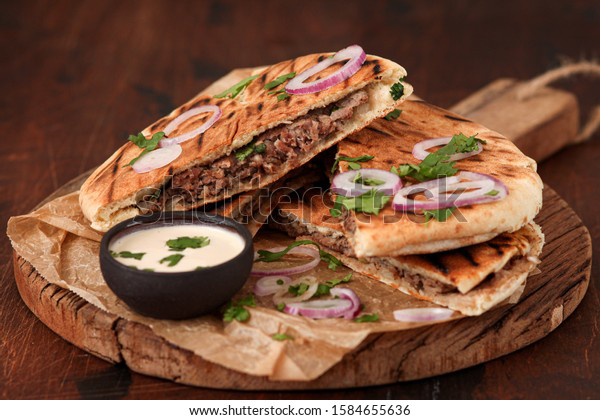

In [577]:
read_image_from_url(url)

In [43]:
selected = selected.reset_index(drop=True)

In [44]:
clip = series2tensor(selected['clip'])

In [45]:
dropped = drop_vector(clip,0)

In [48]:
initscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))

In [49]:
initscore

tensor([0.2959], dtype=torch.float64)

In [46]:
testscore = cos(image_clip.reshape(1,768), dropped.mean(0).reshape(1,768))

In [47]:
testscore

tensor([0.2958], dtype=torch.float64)

In [10]:
clip

tensor([[-0.0134,  0.0236, -0.0090,  ..., -0.0196, -0.0426, -0.0196],
        [-0.0095,  0.0263, -0.0034,  ..., -0.0126, -0.0527, -0.0198],
        [-0.0159,  0.0291,  0.0129,  ..., -0.0046, -0.0566, -0.0300],
        ...,
        [-0.0023,  0.0206, -0.0077,  ...,  0.0501,  0.0134,  0.0433],
        [ 0.0071,  0.0115,  0.0154,  ...,  0.0072, -0.0569,  0.0140],
        [ 0.0154, -0.0088,  0.0130,  ..., -0.0017, -0.0147, -0.0298]],
       dtype=torch.float64)

In [72]:
selected['altered_description'] = 'I am going to eat some ' +selected['description'].str.split(',').apply(lambda l:' '.join(list(reversed(l)))) #selected['category']#+' '+selected['description'].str.replace(',','') I am going to eat some 

In [73]:
clip = []
for i in selected.index:
    text = selected.loc[i,'altered_description']
    clip.append(requests.post(f'https://guru.skynet.center/text2vector/?text={text}').json())
selected['clip'] = clip

In [74]:
selected = selected.reset_index(drop=True)
clip = series2tensor(selected['clip'])
initscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))

In [82]:

selected = selected.reset_index(drop=True)
for i in reversed(selected.index):
    clip = series2tensor(selected['clip'])
    T = torch.cat([clip, clip[i].reshape(1,768)])
    testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
    if testscore > initscore: 
        selected = selected.append(selected.loc[i])
        
        # print(f"added {selected.loc[i,'description']}")
        initscore = testscore
    else:

        T = torch.cat([clip[0:i], clip[i+1:]])
        testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
        if testscore > initscore: 
            r = selected.loc[i,'altered_description']
            selected = selected.drop(i)
            initscore = testscore
            # print(f"removed {r}")




print(initscore)
count = selected.groupby('altered_description')['clip'].count().sort_index()
r = selected.drop_duplicates('altered_description').set_index("altered_description").sort_index()
r['count'] = count
r = r.sort_values('count',ascending = False)
r['cumcount'] = r['count'].cumsum()/r['count'].sum()
r

tensor([0.2570], dtype=torch.float64)


,id,description,clip,score,count,cumcount
altered_description,,,,,,
I am going to eat some water added) deli meat (96%fat free pre-packaged sliced Ham,54,"Ham, sliced, pre-packaged, deli meat (96%fat f...","[0.0633372813463211, 0.04022347554564476, -0.0...",0.184713,7,0.318182
I am going to eat some beech Mushroom,221,"Mushroom, beech","[0.04281458631157875, 0.02264821156859398, 0.0...",0.159764,6,0.590909
I am going to eat some shelf stable from concentrate with added ingredients Tomato juice,214,"Tomato juice, with added ingredients, from con...","[0.035808976739645004, -0.0057374900206923485,...",0.153633,4,0.772727
I am going to eat some raw pollock Fish,61,"Fish, pollock, raw","[0.035080842673778534, -0.012213458307087421, ...",0.177531,3,0.909091
I am going to eat some commercially prepared whole-wheat Bread,74,"Bread, whole-wheat, commercially prepared","[0.013175630010664463, -0.002125881612300873, ...",0.238623,1,0.954545
I am going to eat some navels (Includes foods for USDA's Food Distribution Program) raw Oranges,37,"Oranges, raw, navels (Includes foods for USDA'...","[0.06728268414735794, 0.011319098994135857, -0...",0.174479,1,1.000000


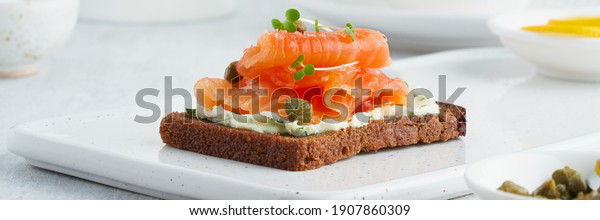

In [76]:
read_image_from_url(url)